# Instructions
- Before running the jupyter notebook, don't forget to copy it into your drive **(`File` => `Save a copy in Drive`)**. *Failing to do this step may result in losing the progress of your code.*
- Change your resource type to GPU before progressing **(`Runtime` => `Change runtime time` => `T4 GPU`).**
- There are six steps for this exercise (including step 0, the preperation step). You will complete the the code blocks denoted by **`TODO:`**.

# Step 0: Preperation

**Step 0.1:** Install dependency
- This step could take a while.

**Step 0.2:** Mount data and files to your drive (optional).
- This is useful if you want to save your model weights, etc.
- You will see a few popup windows asking for your authorization for this notebook to access your Google Drive files. You need to say yes to all of them.

In [ ]:
# Step 0.1: Install dependency and download codebase
# %pip install torch transformers datasets tqdm matplotlib
# !mkdir checkpoints

In [ ]:
# Step 0.2: Mount data and files to your drive (optional).
# from google.colab import drive
# drive.mount('/content/drive')

# Step 1: Defining PyTorch Dataset and Dataloader

First, you will implement a dataset class (named `SST2Dataset`) for processing the SST-2 dataset. You can find details of the basics of Dataset and Dateloader in this [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

We defined the `SST2Example` class for you, which is used to convert a dict of raw data into an SST2Example object that contains a text and label.

In [1]:
# Load necessary packages
from dataclasses import dataclass
from typing import List, Tuple

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizerFast, AutoTokenizer
from datasets import load_dataset

######################################################
#  The following code is given to you.
######################################################

@dataclass
class SST2Example:
    """
    Convert a dict of raw data into an SST2Example object that contains a text and label.
    If you're interested, you can find descriptions of dataclass at https://docs.python.org/3/library/dataclasses.html
    """
    text: str
    label: int  # 0 for negative, 1 for positive

    @staticmethod
    def from_dict(data: dict):
        text = data['text']
        label = data['label']

        return SST2Example(
            text=text,
            label=label,
        )


def initialize_datasets(tokenizer: PreTrainedTokenizerFast) -> dict:
    """
    Initialize the dataset objects for all splits based on the raw data.
    :param tokenizer: A tokenizer used to prepare the inputs for a model (see details in https://huggingface.co/docs/transformers/main_classes/tokenizer).
    :return: A dictionary of the dataset splits.
    """
    raw_data = load_dataset("gpt3mix/sst2")
    split_datasets = {}

    for split_name in raw_data.keys():
        split_data = list(raw_data[split_name])

        split_datasets[split_name] = SST2Dataset(tokenizer, split_data)

    return split_datasets

## **Coding Exercises** for Step 1:
Below, we provide a skeleton for creating a SST-3 Dataset object. **You will complete the following code blocks denoted by `TODO:`.**  
You can read more about `PreTrainedTokenizerFast` [here](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.__call__) (e.g., why do we set `padding`, `max_length`, `truncation`, and `return_tensors` to the values provided below).

In [2]:
class SST2Dataset(Dataset):
    """
    Create a customized dataset object for SST-2.
    A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
    You can find a detailed tutorial on Dataset at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.
    """
    tokenizer: PreTrainedTokenizerFast = None

    def __init__(self, tokenizer: PreTrainedTokenizerFast, raw_data_list: List[dict]):
        SST2Dataset.tokenizer = tokenizer
        self.sample_list = [SST2Example.from_dict(data) for data in raw_data_list]

    def __len__(self):
        """
        Get the number of items in the dataset.
        """
        # TODO: return the number of samples in sample_list.
        return len(self.sample_list)

    def __getitem__(self, idx):
        """
        Get the idx-th item from the dataset.
        """
        # TODO: return the idx-th item in sample_list.
        return self.sample_list[idx]

    def __iter__(self):
        """
        Get an iterator for the dataset.
        """
        # TODO: return an iterator for sample_list.
        return iter(self.sample_list)

    @staticmethod
    def collate_fn(batched_samples: List[SST2Example]) -> dict:
        """
        Encode samples in batched_samples: tokenize the input texts, and turn labels into a tensor.
        :param batched_samples: A list of SST2Example samples.
        :return: A dictionary of encoded texts and their corresponding labels (in tensors).
        """
        # TODO: collect all input texts from batched_samples into a list.
        batched_text = [sample.text for sample in batched_samples]

        # TODO: collect all labels from batched_samples into a list.
        batched_label = [sample.label for sample in batched_samples]

        # Tokenize the input texts.
        text_encoding = SST2Dataset.tokenizer(batched_text,
                                              padding=True,
                                              max_length=512,
                                              truncation=True,
                                              return_tensors="pt")

        # TODO: convert data type of the labels to torch.long (Hint: using torch.LongTensor).
        label_encoding = torch.LongTensor(batched_label)

        # TODO: return dictionary of encoded texts and labels.
        return {
            "input_ids": text_encoding["input_ids"],
            "attention_mask": text_encoding["attention_mask"],
            "labels": label_encoding
        }

# Step 2: Loading Data
Here, you will load the data using the Dataloader of the dataset you built from the previous step.

## **Coding Exercises** for Step 2:
You will complete the following code blocks denoted by `TODO:`.

In [3]:
"""
Load train / validation / test dataset, using `initialize_datasets` in `dataset.py`.
"""
# TODO: load pre-trained tokenizer for roberta-base from transformers library.
# See more examples here: https://huggingface.co/docs/transformers/v4.37.0/en/model_doc/roberta#transformers.RobertaForSequenceClassification.forward.example
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# TODO: load datasets using initialize_datasets.
datasets = initialize_datasets(tokenizer)

# TODO: get the first data point in your validation dataset.
# Hint: (for you to debug) you returned data point should look like `SST2Example(text="It 's a lovely ...", label=0)`
val_first_element = datasets['validation'][0]

# TODO: get the length of train, validation, and test datasets using `datasets` variable.
length_train = len(datasets['train'])
length_val = len(datasets['validation'])
length_test = len(datasets['test'])

"""
To load batch of samples from `torch.Dataset` during training / inference, we use `DataLoader` class.
Below, we provide an example of loading a dataloader for the validation split of SST-2.
"""
validation_dataloader = DataLoader(datasets['validation'],
                                   batch_size=64,
                                   shuffle=False,
                                   collate_fn=SST2Dataset.collate_fn,
                                   num_workers=2)

# TODO: load the first batch of samples from the validation dataset
# Hint: use iterator!
batch = next(iter(validation_dataloader))


# Step 3: Training and Evaluation

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer, AdamW
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## **Coding Exercises** for Step 3:
Here, we provide a skeleton for two functions, `train_one_epoch` and `evaluate`. **You will complete code blocks denoted by `TODO:`.**  
You can learn more about optimizers and the basic structure of a training loop in [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html).

In [5]:
def train_one_epoch(model: nn.Module, dataloader: DataLoader, optimizer: Optimizer, epoch: int):
    """
    Train the model for one epoch.
    :param model: A pre-trained model loaded from transformers. (e.g., RobertaForSequenceClassification https://huggingface.co/docs/transformers/v4.37.0/en/model_doc/roberta#transformers.RobertaForSequenceClassification)
    :param dataloader: A train set dataloader for SST2Dataset.
    :param optimizer: An instance of Pytorch optimizer. (e.g., AdamW https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)
    :param epoch: An integer denoting current epoch.
    Trains model for one epoch.
    """
    # TODO: set the model to the training mode.
    model.train()

    with tqdm(dataloader, desc=f"Train Ep {epoch}", total=len(dataloader)) as tq:
        for batch in tq:
            # TODO: retrieve the data from your batch and send it to the same device as your model (i.e., model.device).
            # Hint: model.device should point to 'cuda' as you set it as such in the main function below.
            #       However, please use `model.device` and don't hard code it to 'cuda' as the auto-grader will put the model on CPU.
            text_encoding = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
            label_encoding = batch['labels'].to(model.device)

            # TODO: Compute loss by running model with text_encoding and label_encoding.
            outputs = model(**text_encoding, labels=label_encoding)
            loss = outputs.loss

            # TODO: compute gradients and update parameters using optimizer.
            # Hint: you need three lines of code here!
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tq.set_postfix({"loss": loss.detach().item()}) # for printing better-looking progress bar

In [6]:
def evaluate(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Evaluate model on the dataloader and compute the accuracy.
    :param model: A language model loaded from transformers. (e.g., RobertaForSequenceClassification https://huggingface.co/docs/transformers/v4.37.0/en/model_doc/roberta#transformers.RobertaForSequenceClassification)
    :param dataloader: A validation / test set dataloader for SST2Dataset
    :return: A floating number representing the accuracy of model in the given dataset.
    """
    # TODO: set the model to the evaluation mode.
    model.eval()

    all_predictions = []
    all_labels = []
    with tqdm(dataloader, desc=f"Eval", total=len(dataloader)) as tq:
        for batch in tq:
            with torch.no_grad():
                # TODO: retrieve the data from your batch and send it to the same device as your model (i.e., model.device).
                # Hint: model.device should point to 'cuda' as you set it as such in the main function below.
                #       However, please use `model.device` and don't hard code it to 'cuda' as the auto-grader will put the model on CPU.
                text_encoding = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
                label_encoding = batch['labels'].to(model.device)

                # TODO: inference with model and compute logits.
                outputs = model(**text_encoding)
                logits = outputs.logits # Hint: logit should be of size (batch_size, 2)

                # TODO: compute list of predictions and list of labels for the current batch
                predictions = torch.argmax(logits, dim=1).tolist() # Hint: should be a list [0, 1, ...] of predicted labels
                labels = label_encoding.tolist() # Hint: should be a list [0, 1, ...] of ground-truth labels

                all_predictions += predictions
                all_labels += labels

    # compute accuracy
    all_predictions = torch.Tensor(all_predictions)
    all_labels = torch.Tensor(all_labels)
    accuracy = compute_accuracy(all_predictions, all_labels)

    print(f"Accuracy: {accuracy}")
    return accuracy


def compute_accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    """
    Given two tensors predictions and labels, compute the accuracy.
    :param predictions: torch.Tensor of size (N,)
    :param labels: torch.Tensor of size (N,)
    :return: A floating number representing the accuracy
    """
    assert predictions.size(-1) == labels.size(-1)

    # TODO: compute accuracy
    accuracy = (predictions == labels).float().mean().item()
    return accuracy

# Step 4: Main Training Loop

The main function uses all the functions implemented above to learn a model for certain number of epochs and evaluate it. Read through the comments and implement `main` that fine-tunes the RoBERTa-based on SST-2.

## **Coding Exercises** for Step 4:
Here, we provide a skeleton for the `main` function. **You will complete code blocks denoted by `TODO:`.**

In [7]:
torch.manual_seed(64)

def main():
    # hyper-parameters (we provide initial set of values here, but you can modify them.)
    batch_size = 64
    learning_rate = 5e-5
    num_epochs = 10
    model_name = "roberta-base"

    # TODO: load pre-trained model and corresponding tokenizer (given model_name above).
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # load model on GPU.
    model = model.cuda()

    # TODO: initialize the AdamW optimizer with optional arguments: lr=learning_rate, eps=1e-8
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

    # TODO: load datasets.
    datasets = initialize_datasets(tokenizer)

    # TODO: initialize that training and evaluation (validation / test) dataloaders.
    # Hint: you should use the validation dataset during hyperparameter tuning,
    # and evaluate the model on the test set once after you finalize the design choice of your model.
    # Hint: you should shuffle the training data, but not the validation data.
    train_dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=SST2Dataset.collate_fn)
    validation_dataloader = DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, collate_fn=SST2Dataset.collate_fn)

    # training loop.
    best_acc = 0.0
    for epoch in range(1, num_epochs + 1):
        train_one_epoch(model, train_dataloader, optimizer, epoch)
        valid_acc = evaluate(model, validation_dataloader)

        # TODO: if the newly trained model checkpoint is better than the previously
        # saved checkpoint, save the new model in `./checkpoints` folder.
        # Hint: remember to update best_acc to the accuracy of the best model so far.
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), './checkpoints/best_model.pth')
            print(f"New best model saved with accuracy: {best_acc:.4f}")


In [8]:
from tqdm.notebook import tqdm
tqdm(range(10))

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# Run the main training loop.
# NOTE: if implemented well, each training epoch will take less than 2 minutes.
main()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Ep 1:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9002293348312378
New best model saved with accuracy: 0.9002


Train Ep 2:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9277523159980774
New best model saved with accuracy: 0.9278


Train Ep 3:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9243119359016418


Train Ep 4:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9288991093635559
New best model saved with accuracy: 0.9289


Train Ep 5:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9231651425361633


Train Ep 6:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9231651425361633


Train Ep 7:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9105504751205444


Train Ep 8:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9185779690742493


Train Ep 9:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.8841742873191833


Train Ep 10:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9048165082931519


# Step 5: Testing the Final Model

## **Coding Exercises** for Step 5:
Here, you load your best trained model from `./checkpoints/` and report the test set accuracy. **You will complete the following code blocks denoted by `TODO:`.**



In [10]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# TODO: Load your best trained model from `./checkpoints/` and report the test set accuracy.
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.load_state_dict(torch.load('./checkpoints/best_model.pth'))
model = model.cuda()

datasets = initialize_datasets(tokenizer)
# TODO: Load the test dataset
test_dataloader = DataLoader(datasets['test'], batch_size=64, shuffle=False, collate_fn=SST2Dataset.collate_fn)

# TODO: evaluate the model on the test set
test_accuracy = evaluate(model, test_dataloader)
print(f"Test set accuracy: {test_accuracy:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Eval:   0%|          | 0/29 [00:00<?, ?it/s]

Accuracy: 0.9412410855293274
Test set accuracy: 0.9412


# Further Exploration, for write-ups:

## 2. Plotting Training and Validation Accuracy Curves

In [12]:
# @ray.remote(num_gpus=1)
def main_test(batch_size=64, learning_rate=5e-5, num_epochs=20, model_name="roberta-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model = model.cuda()
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    datasets = initialize_datasets(tokenizer)
    train_dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=SST2Dataset.collate_fn)
    validation_dataloader = DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, collate_fn=SST2Dataset.collate_fn)

    train_accuracies = []
    valid_accuracies = []
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        train_one_epoch(model, train_dataloader, optimizer, epoch)
        train_acc = evaluate(model, train_dataloader)
        valid_acc = evaluate(model, validation_dataloader)

        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), './checkpoints/best_model_2.pth')
            print(f"New best model saved with accuracy: {best_acc:.4f}")

    return train_accuracies, valid_accuracies


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Ep 1:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9544797539710999


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.91399085521698
New best model saved with accuracy: 0.9140


Train Ep 2:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9653179049491882


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9094036817550659


Train Ep 3:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.99190753698349


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9220183491706848
New best model saved with accuracy: 0.9220


Train Ep 4:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9955202341079712


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9311926364898682
New best model saved with accuracy: 0.9312


Train Ep 5:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9968208074569702


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9185779690742493


Train Ep 6:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9955202341079712


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9151375889778137


Train Ep 7:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9972543120384216


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9094036817550659


Train Ep 8:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9991329312324524


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9231651425361633


Train Ep 9:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 1.0


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9174311757087708


Train Ep 10:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9965317845344543


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9128440618515015


Train Ep 11:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9997109770774841


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9231651425361633


Train Ep 12:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9998555183410645


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9288991093635559


Train Ep 13:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 1.0


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9300458431243896


Train Ep 14:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9994219541549683


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9288991093635559


Train Ep 15:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9988439083099365


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9208715558052063


Train Ep 16:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9984104037284851


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9197247624397278


Train Ep 17:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9997109770774841


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9220183491706848


Train Ep 18:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9992774724960327


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9266055226325989


Train Ep 19:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.994508683681488


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9071100950241089


Train Ep 20:   0%|          | 0/109 [00:00<?, ?it/s]

Eval:   0%|          | 0/109 [00:00<?, ?it/s]

Accuracy: 0.9984104037284851


Eval:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy: 0.9036697149276733


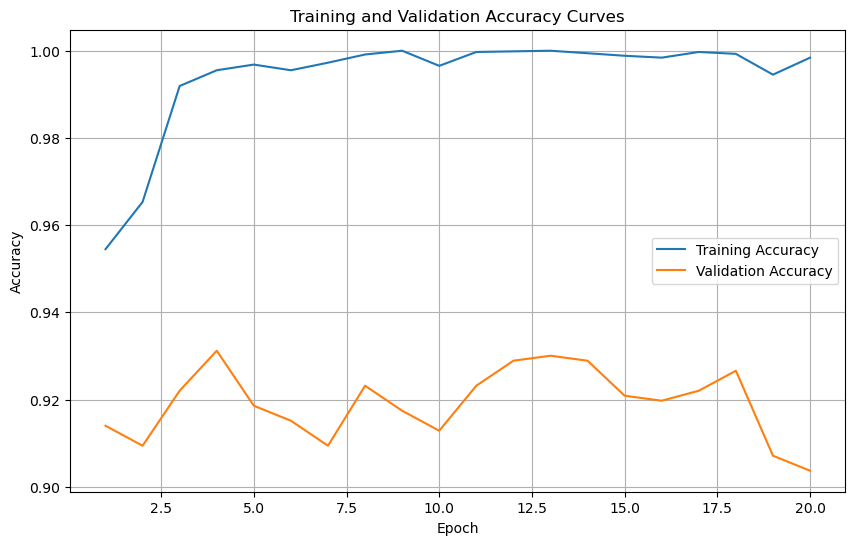

In [13]:
# Run the main function with default hyperparameters
train_acc, valid_acc = main_test()
# future = main_test.remote()
# train_acc, valid_acc = ray.get(future)

# Plot the accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_acc, label='Training Accuracy')
plt.plot(range(1, 21), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()

## 3. Describing the Behavior of Training and Validation Curves


In [14]:
best_train_epoch = train_acc.index(max(train_acc)) + 1
best_train_acc = max(train_acc)
best_valid_epoch = valid_acc.index(max(valid_acc)) + 1
best_valid_acc = max(valid_acc)

print(f"Best training accuracy: {best_train_acc:.4f} at epoch {best_train_epoch}")
print(f"Best validation accuracy: {best_valid_acc:.4f} at epoch {best_valid_epoch}")


Best training accuracy: 1.0000 at epoch 9
Best validation accuracy: 0.9312 at epoch 4


Looking at the accuracy graphs, it is clear that model is overfitting to training data after epoch 5, giving no increase in accuracy in next epochs, with some random fluctutions. It is even better confirmed with the best validation accuracy being achieved at epoch 4.

In [19]:
# PERSONAL EXPERIMENTS:
# import ray
# ray.init(address="ray://192.168.1.21:10001")
# print(ray.nodes())

# @ray.remote
# def train_model():
#     import time
#     time.sleep(5)  # Simulating training
#     return "Training completed on remote machine"
#
# # Run training on the remote node
# future = train_model.remote()
# print(ray.get(future))


## 4. Experimenting with Different Hyperparameters

In [21]:
# same main_test, but with early stopping to save some time
def main_test(batch_size=64, learning_rate=5e-5, num_epochs=20, model_name="roberta-base", patience=4, checkpoint_path="./checkpoints/best_model_4.pth"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model = model.cuda()
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    datasets = initialize_datasets(tokenizer)
    train_dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=SST2Dataset.collate_fn)
    validation_dataloader = DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, collate_fn=SST2Dataset.collate_fn)

    train_accuracies = []
    valid_accuracies = []
    best_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(1, num_epochs + 1):
        train_one_epoch(model, train_dataloader, optimizer, epoch)
        train_acc = evaluate(model, train_dataloader)
        valid_acc = evaluate(model, validation_dataloader)

        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), checkpoint_path)
            print(f"New best model saved with accuracy: {best_acc:.4f}")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break

    return train_accuracies, valid_accuracies


def hyperparameter_search():
    hyperparameters = [
        {'batch_size': 5, 'learning_rate': 1e-6, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_1.pth'},
        {'batch_size': 20, 'learning_rate': 5e-5, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_2.pth'},
        {'batch_size': 100, 'learning_rate': 1e-4, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_3.pth'},
    ]

    best_valid_acc = 0
    best_params = None

    for params in hyperparameters:
        print(f"Training with parameters: {params}")
        _, valid_acc = main_test(**params)
        final_valid_acc = valid_acc[-1]

        if final_valid_acc > best_valid_acc:
            best_valid_acc = final_valid_acc
            best_params = params

    return best_params, best_valid_acc

best_params, best_acc = hyperparameter_search()
print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_acc:.4f}")

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.load_state_dict(torch.load('./checkpoints/best_model_4_1.pth'))
model = model.cuda()
datasets = initialize_datasets(tokenizer)

train_dataloader = DataLoader(datasets['train'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
valid_dataloader = DataLoader(datasets['validation'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
test_dataloader = DataLoader(datasets['test'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)

train_accuracy = evaluate(model, train_dataloader)
valid_accuracy = evaluate(model, valid_dataloader)
test_accuracy = evaluate(model, test_dataloader)

print(f"model 4-1 results: {test_accuracy:.4f}")

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.load_state_dict(torch.load('./checkpoints/best_model_4_2.pth'))
model = model.cuda()
datasets = initialize_datasets(tokenizer)

train_dataloader = DataLoader(datasets['train'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
valid_dataloader = DataLoader(datasets['validation'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
test_dataloader = DataLoader(datasets['test'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)

train_accuracy = evaluate(model, train_dataloader)
valid_accuracy = evaluate(model, valid_dataloader)
test_accuracy = evaluate(model, test_dataloader)

print(f"model 4-2 results: {test_accuracy:.4f}")

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.load_state_dict(torch.load('./checkpoints/best_model_4_3.pth'))
model = model.cuda()
datasets = initialize_datasets(tokenizer)

train_dataloader = DataLoader(datasets['train'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
valid_dataloader = DataLoader(datasets['validation'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
test_dataloader = DataLoader(datasets['test'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)

train_accuracy = evaluate(model, train_dataloader)
valid_accuracy = evaluate(model, valid_dataloader)
test_accuracy = evaluate(model, test_dataloader)

print(f"model 4-3 results: {test_accuracy:.4f}")

# Note: Describe your strategy for hyperparameter tuning in your write-up.

Training with parameters: {'batch_size': 5, 'learning_rate': 1e-06, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_1.pth'}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Ep 1:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9297688007354736


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9025229215621948
New best model saved with accuracy: 0.9025


Train Ep 2:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9463872909545898


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9162843823432922
New best model saved with accuracy: 0.9163


Train Ep 3:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9606936573982239


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9254587292671204
New best model saved with accuracy: 0.9255


Train Ep 4:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9715318083763123


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9266055226325989
New best model saved with accuracy: 0.9266


Train Ep 5:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9791907668113708


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9277523159980774
New best model saved with accuracy: 0.9278


Train Ep 6:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9819363951683044


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9243119359016418


Train Ep 7:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9884393215179443


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9254587292671204


Train Ep 8:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9913294911384583


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9266055226325989


Train Ep 9:   0%|          | 0/1384 [00:00<?, ?it/s]

Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9950867295265198


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9277523159980774
Early stopping triggered. No improvement for 4 epochs.
Training with parameters: {'batch_size': 20, 'learning_rate': 5e-05, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_2.pth'}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Ep 1:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9543352723121643


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.9151375889778137
New best model saved with accuracy: 0.9151


Train Ep 2:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9770231246948242


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.911697268486023


Train Ep 3:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.967196524143219


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.8910550475120544


Train Ep 4:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9958092570304871


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.9197247624397278
New best model saved with accuracy: 0.9197


Train Ep 5:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9921965599060059


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.9002293348312378


Train Ep 6:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9955202341079712


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.9025229215621948


Train Ep 7:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9981213808059692


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.9094036817550659


Train Ep 8:   0%|          | 0/346 [00:00<?, ?it/s]

Eval:   0%|          | 0/346 [00:00<?, ?it/s]

Accuracy: 0.9978323578834534


Eval:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.9036697149276733
Early stopping triggered. No improvement for 4 epochs.
Training with parameters: {'batch_size': 100, 'learning_rate': 0.0001, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_3.pth'}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Ep 1:   0%|          | 0/70 [00:00<?, ?it/s]

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.9433525800704956


Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.9082568883895874
New best model saved with accuracy: 0.9083


Train Ep 2:   0%|          | 0/70 [00:00<?, ?it/s]

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.9816473722457886


Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.9254587292671204
New best model saved with accuracy: 0.9255


Train Ep 3:   0%|          | 0/70 [00:00<?, ?it/s]

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.9842485785484314


Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.9174311757087708


Train Ep 4:   0%|          | 0/70 [00:00<?, ?it/s]

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.9809248447418213


Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.9162843823432922


Train Ep 5:   0%|          | 0/70 [00:00<?, ?it/s]

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.9949421882629395


Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.9128440618515015


Train Ep 6:   0%|          | 0/70 [00:00<?, ?it/s]

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

Accuracy: 0.9965317845344543


Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.9151375889778137
Early stopping triggered. No improvement for 4 epochs.
Best hyperparameters: {'batch_size': 5, 'learning_rate': 1e-06, 'num_epochs': 20, 'checkpoint_path': './checkpoints/best_model_4_1.pth'}
Best validation accuracy: 0.9278


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9791907668113708


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9277523159980774


Eval:   0%|          | 0/365 [00:00<?, ?it/s]

Accuracy: 0.9467325806617737
model 4-1 results: 0.9467


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9958092570304871


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9197247624397278


Eval:   0%|          | 0/365 [00:00<?, ?it/s]

Accuracy: 0.9242174625396729
model 4-2 results: 0.9242


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9816473722457886


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9254587292671204


Eval:   0%|          | 0/365 [00:00<?, ?it/s]

Accuracy: 0.9373970627784729
model 4-3 results: 0.9374


From the output, we can see that model 4-1 performs the best on the test set with accuracy of 0.9467.

## 5. Final Model Performance

In [22]:
# Load the best model and evaluate on all datasets
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.load_state_dict(torch.load('./checkpoints/best_model_4_1.pth'))
model = model.cuda()

datasets = initialize_datasets(tokenizer)

train_dataloader = DataLoader(datasets['train'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
valid_dataloader = DataLoader(datasets['validation'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)
test_dataloader = DataLoader(datasets['test'], batch_size=best_params['batch_size'], shuffle=False, collate_fn=SST2Dataset.collate_fn)

train_accuracy = evaluate(model, train_dataloader)
valid_accuracy = evaluate(model, valid_dataloader)
test_accuracy = evaluate(model, test_dataloader)

print(f"Best model hyperparameters:")
print(f"Optimizer: AdamW")
print(f"Batch size: {best_params['batch_size']}")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Number of epochs: {best_params['num_epochs']}")
print(f"\nFinal model performance:")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {valid_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Eval:   0%|          | 0/1384 [00:00<?, ?it/s]

Accuracy: 0.9791907668113708


Eval:   0%|          | 0/175 [00:00<?, ?it/s]

Accuracy: 0.9277523159980774


Eval:   0%|          | 0/365 [00:00<?, ?it/s]

Accuracy: 0.9467325806617737
Best model hyperparameters:
Optimizer: AdamW
Batch size: 5
Learning rate: 1e-06
Number of epochs: 20

Final model performance:
Training accuracy: 0.9792
Validation accuracy: 0.9278
Test accuracy: 0.9467
